# Cargamos el software y se crea la sesión Spark

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder.master("local[*]").getOrCreate()


# Lectura de los datos

In [3]:
housingDF=spark.read.option("header",True).csv("housing_all.csv", inferSchema=True)
housingDF.printSchema()
total = housingDF.count()
print ("Registers:",total)

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemod/Add: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |

# Análisis de los datos

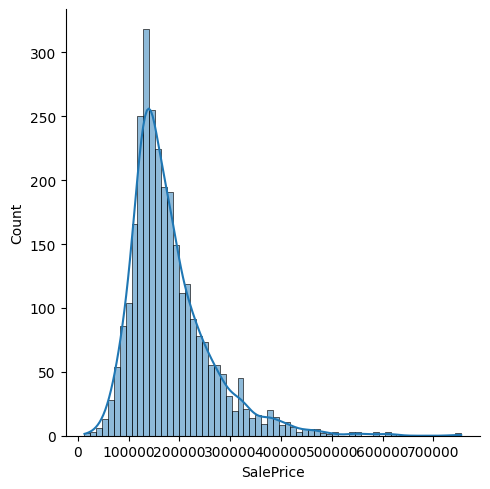

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

pandasDF=housingDF.toPandas()
sns.displot(data=pandasDF['SalePrice'], kde=True)

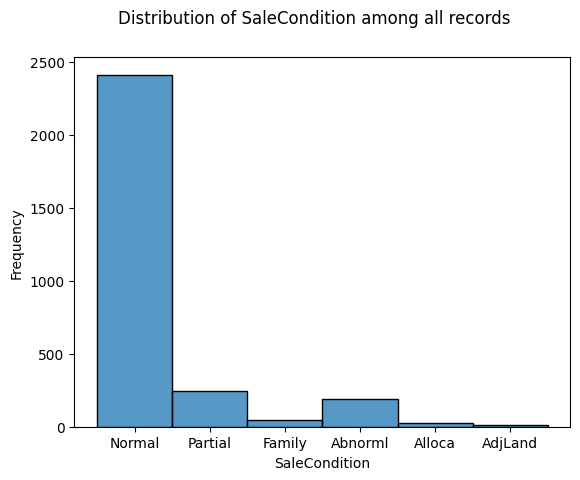

In [5]:
plt.suptitle(f"Distribution of SaleCondition among all records")
plt.ylabel("Frequency")
sns.histplot(pandasDF['SaleCondition']);

In [6]:
from pyspark.sql.functions import round
pandasDF[["MSSubClass","PoolArea","YearBuilt"]].describe().round(2)


,MSSubClass,PoolArea,YearBuilt
count,2930.00,2930.00,2930.00
mean,57.39,2.24,1971.36
std,42.64,35.60,30.25
min,20.00,0.00,1872.00
25%,20.00,0.00,1954.00
50%,50.00,0.00,1973.00
75%,70.00,0.00,2001.00
max,190.00,800.00,2010.00


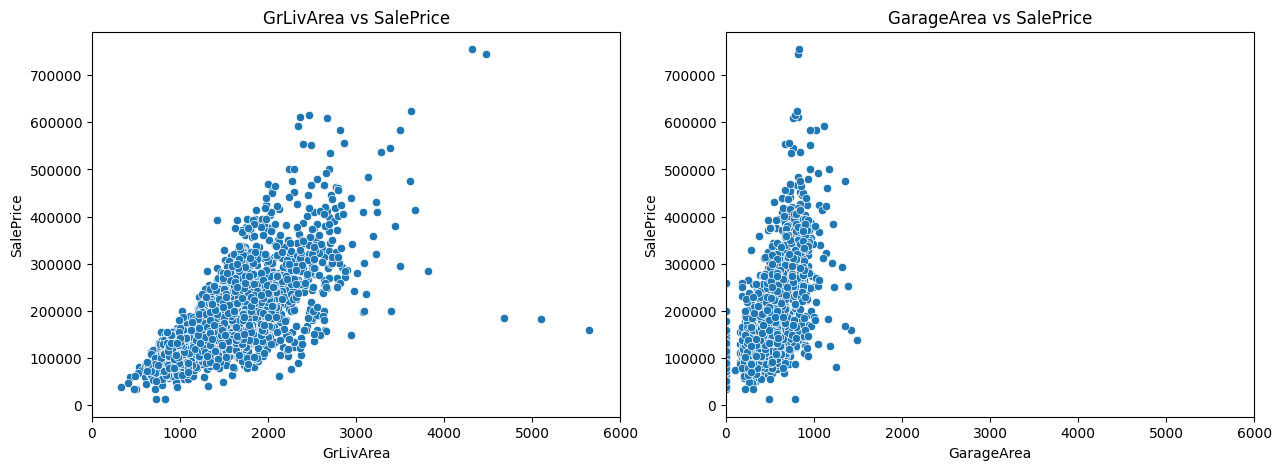

In [7]:
fig1, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))

axes[0].set_xlim(0,6000)

sns.scatterplot(data=pandasDF, ax=axes[0], x="GrLivArea", y="SalePrice")
axes[0].set_title("GrLivArea vs SalePrice")
sns.scatterplot(data=pandasDF, ax=axes[1], x="GarageArea", y="SalePrice")
axes[1].set_title("GarageArea vs SalePrice");

<Axes: title={'center': 'GrvLivArea vs SalePrice'}, xlabel='GrLivArea', ylabel='SalePrice'>

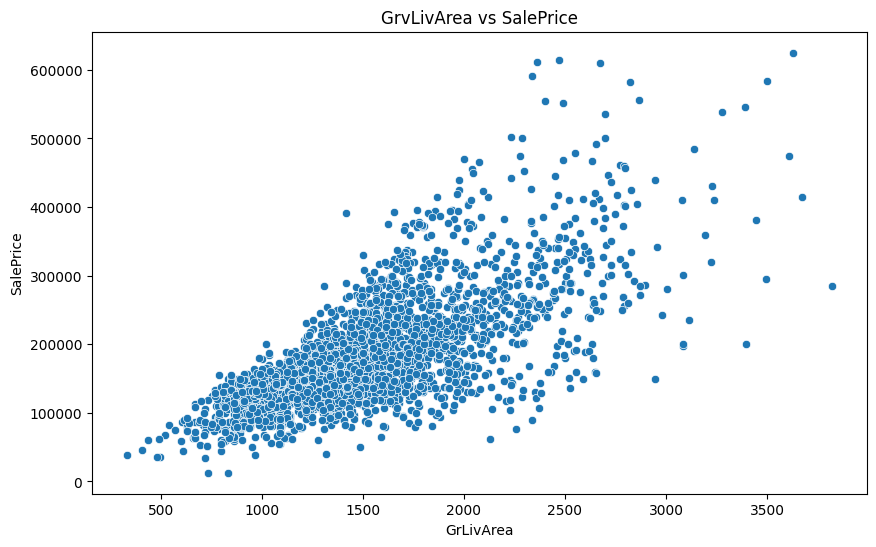

In [8]:
pandasDF2 = pandasDF.loc[(pandasDF["GrLivArea"] < 4000) & (pandasDF["SalePrice"] < 7000000)]
fig2 = plt.figure(figsize=(10,6))
axes = fig2.add_subplot()
axes.set_title("GrvLivArea vs SalePrice")
sns.scatterplot(data=pandasDF2, ax=axes, x="GrLivArea", y="SalePrice")


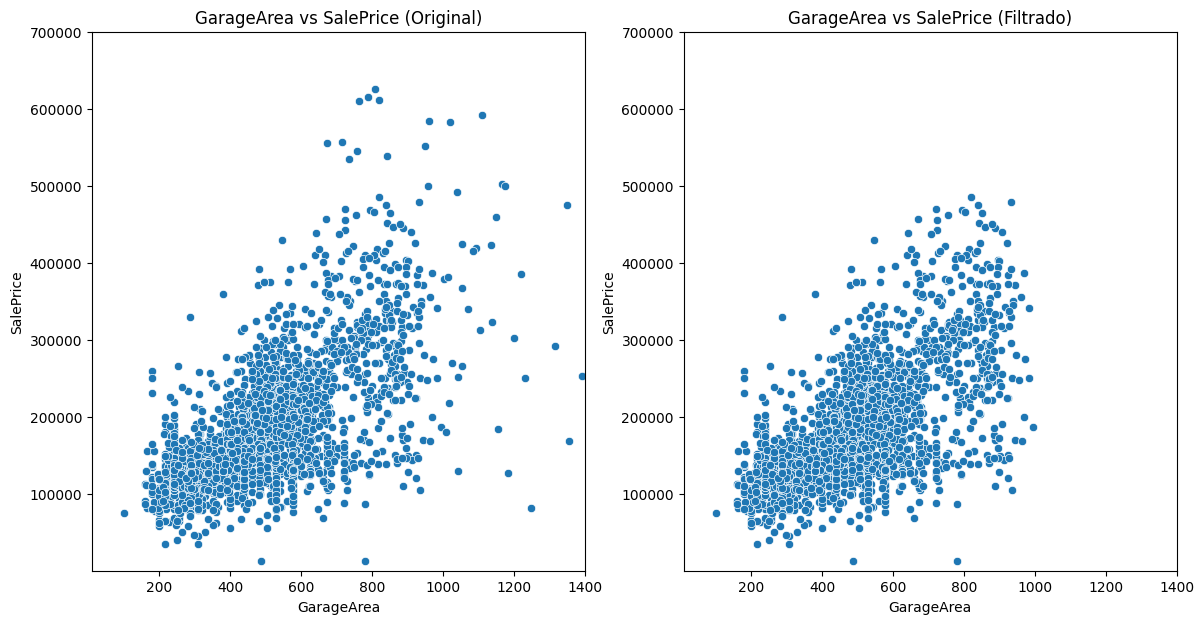

In [10]:
# filtro
filtered_df = pandasDF[(pandasDF['GarageArea'] < 1000) &
(pandasDF['SalePrice'] < 500000)]
# fig
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
x_limits = (10, 1400)
y_limits = (10, 700000)
# datos originales
sns.scatterplot(data=pandasDF, ax=axes[0], x="GarageArea",
y="SalePrice")
axes[0].set_title("GarageArea vs SalePrice (Original)")
axes[0].set_xlim(x_limits)
axes[0].set_ylim(y_limits)
# datos filtrados
sns.scatterplot(data=filtered_df, ax=axes[1], x="GarageArea",
y="SalePrice")
axes[1].set_title("GarageArea vs SalePrice (Filtrado)")
axes[1].set_xlim(x_limits)
axes[1].set_ylim(y_limits)
plt.show()

# Entrenamiento

In [11]:
naCols = pandasDF.columns[pandasDF.isna().any()].tolist()
curatedDF = housingDF[[i for i in pandasDF if i not in naCols]]
col_pandasDF = len(pandasDF.columns)
col_curateDF = len(curatedDF.columns)
print("PandasDF: ",col_pandasDF, "curateDF: ", col_curateDF)


PandasDF:  81 curateDF:  60


In [12]:
numCols = [col for col, dtype in curatedDF.dtypes if dtype != 'string']
indexedDF = curatedDF.select(numCols)
len(indexedDF.columns)

27

In [13]:
num_cols_original = len(pandasDF.columns)
num_cols_curated = len(curatedDF.columns)
print(f"Columnas originales: {num_cols_original}")
print(f"Columnas después del filtro :{num_cols_curated}")
num_cols_numeric = len(indexedDF.columns)
print(f"Columnas numéricas:{num_cols_numeric}")

Columnas originales: 81
Columnas después del filtro :60
Columnas numéricas:27


# Divido el dataset

In [14]:
(trainDF, validationDF) = indexedDF.randomSplit([0.8, 0.2], seed=1)


In [15]:
from pyspark.ml.feature import VectorAssembler

vecAssembler= VectorAssembler(inputCols = trainDF.drop("SalePrice").columns,
				outputCol = "features")

vecTrainDF = vecAssembler.transform(trainDF)
vecTrainDF.show(5,truncate=False)

+---+----------+-------+-----------+-----------+---------+-------------+--------+--------+------------+---------+--------+--------+------------+------------+------------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+---------+------------------------------------------------------------------------------------------------------------------------------------+
|Id |MSSubClass|LotArea|OverallQual|OverallCond|YearBuilt|YearRemod/Add|1stFlrSF|2ndFlrSF|LowQualFinSF|GrLivArea|FullBath|HalfBath|BedroomAbvGr|KitchenAbvGr|TotRmsAbvGrd|Fireplaces|WoodDeckSF|OpenPorchSF|EnclosedPorch|3SsnPorch|ScreenPorch|PoolArea|MiscVal|MoSold|YrSold|SalePrice|features                                                                                                                            |
+---+----------+-------+-----------+-----------+---------+-------------+--------+--------+------------+---------+--------+--------+------------+------------+------------+

In [16]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

scalerModel = scaler.fit(vecTrainDF)
scTrainDF = scalerModel.transform(vecTrainDF)
scTrainDF.show(5, truncate=False)


+---+----------+-------+-----------+-----------+---------+-------------+--------+--------+------------+---------+--------+--------+------------+------------+------------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+---------+------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id |MSSubClass|LotArea|OverallQual|OverallCond|YearBuilt|YearRemod/Add|1stFlrSF|2ndFlrSF|LowQualFinSF|GrLivArea|FullBath|HalfBath|BedroomAbvGr|KitchenAbvGr|TotRmsAbvGrd|Fireplaces|WoodDec

# LR

In [17]:
from pyspark.ml.regression import LinearRegression

lr = (
    LinearRegression(
        featuresCol="features",
        labelCol="SalePrice",
        maxIter=10,
        regParam=0.8,
        elasticNetParam=0.1,
    )
)
lrModel = lr.fit(scTrainDF)

In [18]:
from pyspark.ml import Pipeline
pipeline=Pipeline(stages=[vecAssembler, scaler, lr])
pipelineModel=pipeline.fit(trainDF)
predDF=pipelineModel.transform(validationDF)

predDF.select("prediction","SalePrice","features").show(5)


+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|171226.38781804848|   189900|[5.0,60.0,13830.0...|
|217597.44294040347|   171500|[14.0,20.0,10176....|
|245581.52561407373|   212000|[15.0,120.0,6820....|
| 405269.6524014196|   538000|[16.0,60.0,53504....|
|326596.15905425325|   394432|[18.0,20.0,11394....|
+------------------+---------+--------------------+
only showing top 5 rows



# Evaluación

In [19]:
from pyspark.ml.evaluation import RegressionEvaluator
lrEvaluator = (
    RegressionEvaluator(
        predictionCol="prediction",
        labelCol="SalePrice",
        metricName="r2",
    )
)

r2=lrEvaluator.evaluate(predDF)
#print(r2)

lrSummary = lrModel.summary
print(f"RMSE: {lrSummary.rootMeanSquaredError:f}")
print(f"r2: {lrSummary.r2:f}")

lrPredictions = pipelineModel.transform(validationDF)
lrPredictions.select("prediction","SalePrice","features").show(5)

print(f"R Squared (R2) on val data = {lrEvaluator.evaluate(lrPredictions):g}")

RMSE: 32114.598852
r2: 0.833536
+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|171226.38781804848|   189900|[5.0,60.0,13830.0...|
|217597.44294040347|   171500|[14.0,20.0,10176....|
|245581.52561407373|   212000|[15.0,120.0,6820....|
| 405269.6524014196|   538000|[16.0,60.0,53504....|
|326596.15905425325|   394432|[18.0,20.0,11394....|
+------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.704586


# RF

In [20]:
from pyspark.ml.regression import RandomForestRegressor

rf = (
    RandomForestRegressor(
        featuresCol='features',
        labelCol='SalePrice',
        maxDepth=20,
        minInstancesPerNode=2,
        bootstrap=True,
    )
)

pipeline=Pipeline(stages=[vecAssembler, rf])
pipelineModel=pipeline.fit(trainDF)
predDF=pipelineModel.transform(validationDF)

predDF.select("prediction","SalePrice","features").show(5)

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
| 183442.3722222222|   189900|[5.0,60.0,13830.0...|
|          189819.5|   171500|[14.0,20.0,10176....|
|223802.80666666664|   212000|[15.0,120.0,6820....|
| 370276.3083333333|   538000|[16.0,60.0,53504....|
| 353571.4416666667|   394432|[18.0,20.0,11394....|
+------------------+---------+--------------------+
only showing top 5 rows



# RF Evaluación

In [21]:
rfEvaluator = (
    RegressionEvaluator(
        predictionCol="prediction",
        labelCol="SalePrice",
        metricName="r2",
    )
)
rfPredictions = pipelineModel.transform(validationDF)
rfPredictions.select("prediction","SalePrice","features").show(5)

print(f"R Squared (R2) on val data = {rfEvaluator.evaluate(rfPredictions):g}")

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
| 183442.3722222222|   189900|[5.0,60.0,13830.0...|
|          189819.5|   171500|[14.0,20.0,10176....|
|223802.80666666664|   212000|[15.0,120.0,6820....|
| 370276.3083333333|   538000|[16.0,60.0,53504....|
| 353571.4416666667|   394432|[18.0,20.0,11394....|
+------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.863335


# Cómo puedo ver si hay sobreajuste?

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|         215426.85|   215000|[1.0,20.0,31770.0...|
|120850.38333333333|   105000|[2.0,20.0,11622.0...|
|          164417.5|   172000|[3.0,20.0,14267.0...|
|229448.12499999994|   244000|[4.0,20.0,11160.0...|
|          193107.5|   195500|[6.0,60.0,9978.0,...|
+------------------+---------+--------------------+
only showing top 5 rows

Train RMSE: 13197.193298
Validation RMSE: 31213.022417
Train R2: 0.833536
Validation R2: 0.863335


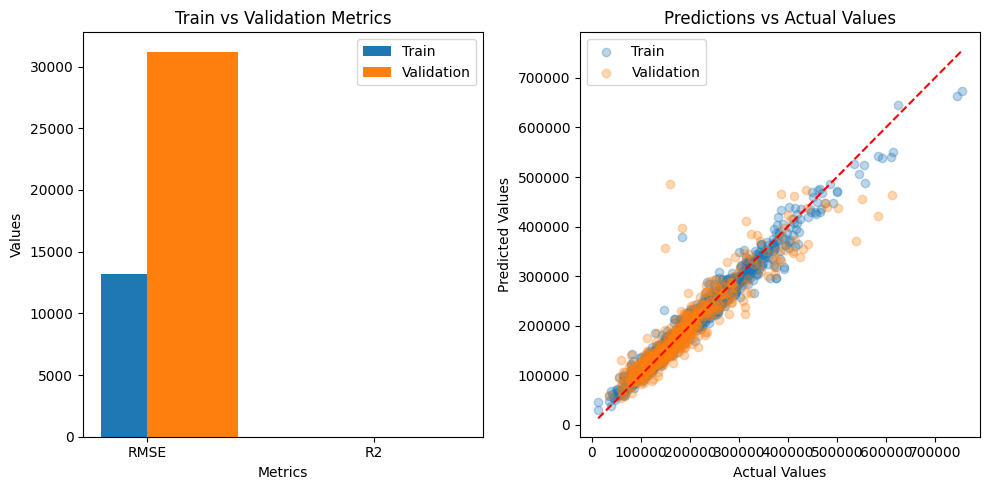

In [22]:
import matplotlib.pyplot as plt
import numpy as np
# Predicciones
trainPredDF = pipelineModel.transform(trainDF)
trainPredDF.select("prediction", "SalePrice", "features").show(5)
# Evaluador RMSE
rmseEvaluator = RegressionEvaluator(predictionCol="prediction",
labelCol="SalePrice", metricName="rmse")
# RMSE Training
trainRMSE = rmseEvaluator.evaluate(trainPredDF)
# RMSE validació
validationRMSE = rmseEvaluator.evaluate(predDF)
# R^2 Training
trainR2 = lrSummary.r2
# R^2 para validació
validationR2 = lrEvaluator.evaluate(predDF)
print(f"Train RMSE: {trainRMSE:f}")
print(f"Validation RMSE: {validationRMSE:f}")
print(f"Train R2: {trainR2:f}")
print(f"Validation R2: {validationR2:f}")
# Visualización de las métricas
metrics = ["RMSE", "R2"]
train_metrics = [trainRMSE, trainR2]
validation_metrics = [validationRMSE, validationR2]
x = range(len(metrics))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(x, train_metrics, width=0.4, label='Train', align='center')
plt.bar(x, validation_metrics, width=0.4, label='Validation',
align='edge')
plt.xticks(x, metrics)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Train vs Validation Metrics")
plt.legend()
# Gràfica de predicciones vs valores reales
train_results = trainPredDF.select("prediction",
"SalePrice").toPandas()
validation_results = predDF.select("prediction",
"SalePrice").toPandas()
min_val = np.minimum(train_results["SalePrice"].min(),
validation_results["SalePrice"].min())
max_val = np.maximum(train_results["SalePrice"].max(),
validation_results["SalePrice"].max())
plt.subplot(1, 2, 2)
plt.scatter(train_results["SalePrice"], train_results["prediction"],
alpha=0.3, label="Train")
plt.scatter(validation_results["SalePrice"],
validation_results["prediction"], alpha=0.3, label="Validation")
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs Actual Values")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# Definimos un conjunto de parámetros para la validación cruzada
paramGrid = (
ParamGridBuilder()
.addGrid(lr.regParam, [0.1, 0.01, 0.001])
.addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
.build()
)
# Definir la validación cruzada
crossval = CrossValidator(
estimator=pipeline,
estimatorParamMaps=paramGrid,
evaluator=RegressionEvaluator(predictionCol="prediction",
labelCol="SalePrice", metricName="rmse"),
numFolds=5)
# nombre de folds per a la validación cruzada

# Ajustar el modelo con la validación cruzada
cvModel = crossval.fit(trainDF)
# Evaluar el model en el conjunt de validació
cvPredictions = cvModel.transform(validationDF)
cvRMSE = rmseEvaluator.evaluate(cvPredictions)
cvR2 = lrEvaluator.evaluate(cvPredictions)
print(f"Cross-Validation RMSE on validation data = {cvRMSE:g}")
print(f"Cross-Validation R² on validation data = {cvR2:g}")